In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import random
import shutil
from tqdm import tqdm

In [3]:
# Cấu hình
original_dir = "/kaggle/input/rice-leaf-disease-image"  # Đường dẫn chứa dữ liệu gốc
output_dir = "dataset"                                    # Thư mục mới chứa tập train_val và test
test_split = 0.2                                         # Tỉ lệ test
VALIDATION_SPLIT = 0.2
IMG_SIZE = (128, 128)                                    # Kích thước ảnh
BATCH_SIZE = 64                                          # Batch size
EPOCHS = 30                                              # Số epoch
random.seed(42)                                          # Đảm bảo reproducibility

# Tách dữ liệu thành train_val và test
train_val_dir = os.path.join(output_dir, 'train_val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lặp qua từng lớp
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Tạo thư mục lớp trong train_val và test
    os.makedirs(os.path.join(train_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Lấy danh sách ảnh, shuffle
    images = os.listdir(class_path)
    random.shuffle(images)

    # Tách
    num_test = int(len(images) * test_split)
    test_images = images[:num_test]
    train_val_images = images[num_test:]

    # Di chuyển ảnh vào đúng nơi
    for img in tqdm(test_images, desc=f"Copying test images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(test_dir, class_name, img)
        )

    for img in tqdm(train_val_images, desc=f"Copying train_val images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(train_val_dir, class_name, img)
        )

print("✅ Đã tách dữ liệu thành công.")
# Kiểm tra cấu trúc dữ liệu
for root, dirs, files in os.walk(output_dir):
    print(root, ":", len(files), "files")

Copying train_val images for Brownspot: 100%|██████████| 1280/1280 [00:08<00:00, 156.30it/s]

✅ Đã tách dữ liệu thành công.
dataset : 0 files
dataset/train_val : 0 files
dataset/train_val/Blast : 1152 files
dataset/train_val/Tungro : 1047 files
dataset/train_val/Brownspot : 1280 files
dataset/train_val/Bacterialblight : 1268 files
dataset/test : 0 files
dataset/test/Blast : 288 files
dataset/test/Tungro : 261 files
dataset/test/Brownspot : 320 files
dataset/test/Bacterialblight : 316 files


In [4]:
# Tạo ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator cho tập train
train_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Tạo generator cho tập validation
val_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Tạo generator cho tập test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Số lượng lớp
NUM_CLASSES = train_generator.num_classes
class_labels = list(val_generator.class_indices.keys())

print(f"Số lớp: {NUM_CLASSES}")
print(f"Số lượng ảnh train: {train_generator.samples}")
print(f"Số lượng ảnh validation: {val_generator.samples}")
print(f"Số lượng ảnh test: {test_generator.samples}")

Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Số lớp: 4
Số lượng ảnh train: 3799
Số lượng ảnh validation: 948
Số lượng ảnh test: 1185


In [6]:
# Xây dựng mô hình CNN
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Biên dịch mô hình với SGD
opt = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Huấn luyện mô hình
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Đánh giá mô hình trên tập validation
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Đánh giá mô hình trên tập test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1748786844.372067     117 service.cc:148] XLA service 0x78edac008ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748786844.374887     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748786844.636799     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/60 ━━━━━━━━━━━━━━━━━━━━ 5:59 6s/step - accuracy: 0.1875 - loss: 1.6797

I0000 00:00:1748786848.792989     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 399ms/step - accuracy: 0.2536 - loss: 1.5114 - val_accuracy: 0.3787 - val_loss: 1.3735
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.2827 - loss: 1.4019 - val_accuracy: 0.3935 - val_loss: 1.3713
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.3075 - loss: 1.3724 - val_accuracy: 0.4367 - val_loss: 1.3633
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.3215 - loss: 1.3712 - val_accuracy: 0.4620 - val_loss: 1.3575
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - accuracy: 0.3526 - loss: 1.3456 - val_accuracy: 0.4325 - val_loss: 1.3484
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - accuracy: 0.3518 - loss: 1.3406 - val_accuracy: 0.4546 - val_loss: 1.3340
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - accuracy: 0.3977 - loss: 1.3039 - val_accuracy: 0.4283 - val_loss: 1.3202
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.3892 - loss: 1.2922 - val_accuracy: 0.469

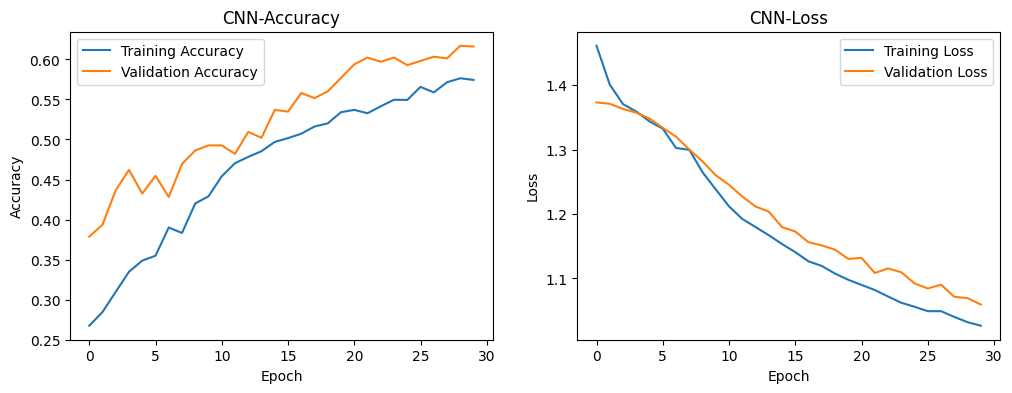

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step
Validation Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.69      0.41      0.52       253
          Blast       0.65      0.41      0.50       230
      Brownspot       0.74      0.82      0.78       256
         Tungro       0.46      0.82      0.59       209

       accuracy                           0.61       948
      macro avg       0.64      0.61      0.60       948
   weighted avg       0.64      0.61      0.60       948



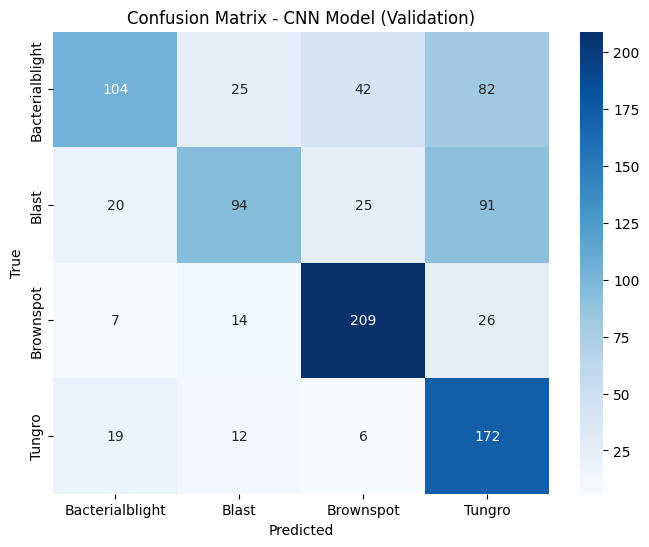

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Test Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.79      0.44      0.57       316
          Blast       0.69      0.51      0.59       288
      Brownspot       0.79      0.84      0.81       320
         Tungro       0.51      0.89      0.64       261

       accuracy                           0.66      1185
      macro avg       0.69      0.67      0.65      1185
   weighted avg       0.70      0.66      0.66      1185



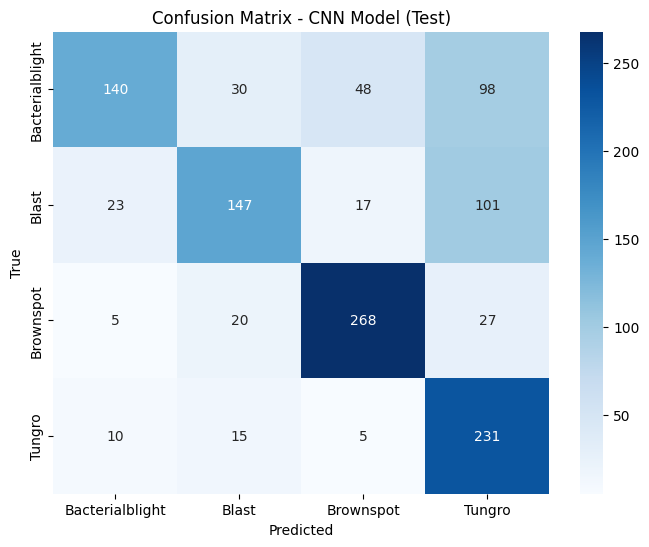

In [9]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN-Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('training_metrics.png')
plt.show()

# Phần đánh giá mô hình trên tập validation
val_generator.reset()  # Reset để đảm bảo thứ tự
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Báo cáo phân loại cho tập validation
print("Validation Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Ma trận nhầm lẫn cho tập validation
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - CNN Model (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix_validation.png')
plt.show()

# Phần đánh giá mô hình trên tập test
test_generator.reset()  # Reset để đảm bảo thứ tự
test_preds = model.predict(test_generator)
test_y_pred = np.argmax(test_preds, axis=1)
test_y_true = test_generator.classes
# Báo cáo phân loại cho tập test
print("Test Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=class_labels))

# Ma trận nhầm lẫn cho tập test
test_conf_mat = confusion_matrix(test_y_true, test_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - CNN Model (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix_test.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
Test image path: dataset/test/Brownspot/BROWNSPOT1_196.jpg
True class: Brownspot
Predicted class: Bacterialblight
Confidence: 0.3790


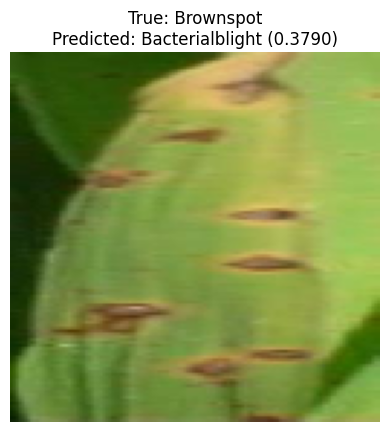

In [10]:
# Phần test ảnh ngẫu nhiên từ tập test
# Lấy danh sách tất cả ảnh trong tập test
image_paths = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))

# Chọn ngẫu nhiên một ảnh
test_img_path = random.choice(image_paths)

# Tải và xử lý ảnh test
img = load_img(test_img_path, target_size=IMG_SIZE)
img_array = img_to_array(img) / 255.0  # Chuẩn hóa ảnh
img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch

# Dự đoán lớp
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Lấy nhãn thật từ đường dẫn
true_class = os.path.basename(os.path.dirname(test_img_path))

# Hiển thị kết quả
print(f"Test image path: {test_img_path}")
print(f"True class: {true_class}")
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.4f}")

# Hiển thị ảnh test
plt.figure()
plt.imshow(img)
plt.title(f"True: {true_class}\nPredicted: {class_labels[predicted_class]} ({confidence:.4f})")
plt.axis('off')
plt.savefig('test_result.png')
plt.show()

# Lưu mô hình
model.save('rice_leaf_disease_model.h5')